# Overview of work completed thus far:

- Data importing
    - Station information 
    - Total daily energy availability (to be predicted by ML model)
    - Weather variable predictions/forecasts
    
- Data wrangling
    - Ran a check for null values - none found
    - Ran a check for erroneous energy values (determined to be values not ending in 0) - these values makeup 0.42% of overall 
      values and will be removed
    - The goal is to create a list of observations (total daily energy availability) for each site on each day and
      combine with  the list of features 
    - This process was done using nested for loops
        - For each station:
        - For each weather prediction/forecast variable:
            - Merge the list of energy data for a specific station with the list of stations
            - Get all weather variable forecasts for all days, forecast hours, gridpoints, 11 predictive models
            - Use only the weather variable forecasts from the latitude and longitude of the closest gridpoint to the station
            - Take the median value of the 11 different predictive models
            - Pivot the forecast hour to be a 5 different columns for each of the 5 forecast hours
            - Merge the weather variable predictions/forecasts for each day with the total energy availability

# Modules Import

In [1]:
# Import necessary modules

import numpy as np
import netCDF4 as nc
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import glob
from functools import reduce

from mpl_toolkits.basemap import Basemap, cm
import seaborn as seabornInstance 

C:\Users\conno\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\conno\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Data Import

In [2]:
# Import the station location data and station energy data

# Station data is the list of 98 Mesonet solar farm IDs, their location (longitude, latitude, elevation)
stations = pd.read_csv('station_info.csv')

# Energy data is the total daily energy availability on each day for each station
energy = pd.read_csv('train.csv', parse_dates=True, index_col='Date')

print(stations.head())
print(energy.head())

   stid      nlat      elon  elev
0  ACME  34.80833 -98.02325   397
1  ADAX  34.79851 -96.66909   295
2  ALTU  34.58722 -99.33808   416
3  APAC  34.91418 -98.29216   440
4  ARNE  36.07204 -99.90308   719
                ACME      ADAX      ALTU      APAC      ARNE      BEAV  \
Date                                                                     
1994-01-01  12384900  11930700  12116700  12301200  10706100  10116900   
1994-01-02  11908500   9778500  10862700  11666400   8062500   9262800   
1994-01-03  12470700   9771900  12627300  12782700  11618400  10789800   
1994-01-04  12725400   6466800  13065300  12817500  12134400  11816700   
1994-01-05  10894800  11545200   8060400  10379400   6918600   9936300   

                BESS      BIXB      BLAC      BOIS  ...      VINI      WASH  \
Date                                                ...                       
1994-01-01  11487900  11182800  10848300  10225200  ...  10771800  12116400   
1994-01-02   9235200   3963300   3318300

In [3]:
# Import the weather variable forecasts
# Forecasts are separated into 15 different files for each forecast variable (e.g. air pressure, specific humidity, etc.)
# Each variable is forecast using 11 different predictive models at 144 gridpoint locations
# (on 16 lines of longitude and 9 lines of latitude)

# Take any filename that ends in .nc and add to a list of the files
weather_file_list = glob.glob('*.nc')

# Take the data from each file in the file list and put into a list of data
list_of_data = [xr.open_dataset(filename) for filename in weather_file_list]

# Convert list of data to a list of dataframes
# Each dataframe consists of forecast data for a single weather variable
list_of_dfs = [data_file.to_dataframe() for data_file in list_of_data]

list_of_dfs[0].head()

intTime  intValidTime  \
ens fhour    lat  lon   time                                   
0   12:00:00 31.0 254.0 1994-01-01  1994010100    1994010112   
                        1994-01-02  1994010200    1994010212   
                        1994-01-03  1994010300    1994010312   
                        1994-01-04  1994010400    1994010412   
                        1994-01-05  1994010500    1994010512   

                                    Total_precipitation  
ens fhour    lat  lon   time                             
0   12:00:00 31.0 254.0 1994-01-01                  0.0  
                        1994-01-02                  0.0  
                        1994-01-03                  0.0  
                        1994-01-04                  0.0  
                        1994-01-05                  0.0

# Missing values and outliers

In [4]:
# Check for null values in energy data
energy.isnull().any().any()

False

In [6]:
# Check for null values in weather variable data
null_check = []

for df in list_of_dfs:
    null_check.append(df.isnull().any().any())

print(null_check)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [7]:
# Check for repeating values as client has stated that pyranometers occasionally do not function correctly
# Repeating values appear to end in a number that is not 0
energy.ACME.value_counts().head()

11010048    13
13517100     4
18781200     3
25608600     2
29627400     2
Name: ACME, dtype: int64

In [8]:
energy.ADAX.value_counts().head()

10223616    14
11530800     3
23339400     3
13851600     3
17067300     2
Name: ADAX, dtype: int64

In [9]:
energy.CLAY.value_counts().head()

12320768    104
15594000      3
12843900      3
12471900      3
7706400       2
Name: CLAY, dtype: int64

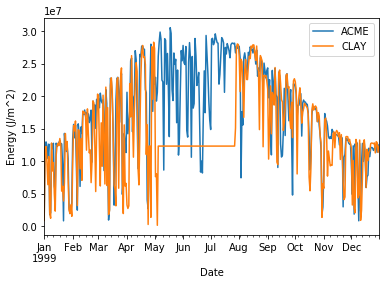

In [10]:
energy.ACME.loc['1999'].plot()
energy.CLAY.loc['1999'].plot()
plt.ylabel('Energy (J/m^2)')
plt.legend()
# Continuous energy value given for CLAY May-July - erroneous

In [11]:
columns = list(energy)
error_val_count = {}

for column in columns:
    for row in range(energy[column].size):
        if str(energy[column][row])[-1] != '0':
            if not column in error_val_count:
                error_val_count[column] = 1
            else:
                error_val_count[column] += 1

In [12]:
error_val_count

{'ACME': 13,
 'ADAX': 14,
 'BEAV': 9,
 'BESS': 25,
 'BIXB': 51,
 'BOWL': 12,
 'BREC': 1,
 'BRIS': 18,
 'BUFF': 19,
 'BURB': 60,
 'BURN': 32,
 'BYAR': 26,
 'CHER': 4,
 'CHEY': 38,
 'CHIC': 22,
 'CLAY': 104,
 'COOK': 5,
 'COPA': 2,
 'ELRE': 6,
 'ERIC': 79,
 'EUFA': 48,
 'FAIR': 301,
 'FORA': 14,
 'FREE': 1,
 'FTCB': 8,
 'GOOD': 92,
 'GUTH': 1,
 'HASK': 63,
 'HOBA': 1,
 'HOLL': 1,
 'HUGO': 10,
 'IDAB': 21,
 'KENT': 3,
 'MADI': 10,
 'MARE': 1,
 'MAYR': 33,
 'MEDI': 26,
 'MIAM': 4,
 'MTHE': 219,
 'NINN': 57,
 'OKEM': 52,
 'OKMU': 69,
 'PRYO': 14,
 'REDR': 5,
 'RETR': 45,
 'RING': 6,
 'SALL': 50,
 'SHAW': 3,
 'SKIA': 1,
 'SLAP': 118,
 'SPEN': 43,
 'STIG': 9,
 'STUA': 2,
 'TALI': 12,
 'TIPT': 1,
 'VINI': 16,
 'WATO': 11,
 'WEST': 149,
 'WILB': 34,
 'WIST': 14,
 'WYNO': 14}

In [13]:
total_errors = sum(error_val_count.values())
total_values = energy.shape[0] * energy.shape[1]
error_value_pct = total_errors / total_values * 100
print('Total Erroneous Values: ' + str(total_errors))
print('Total Values: ' + str(total_values))
print('Percent of Total Values being Erroneous: ' + str(error_value_pct)[0:4] + '%')

Total Erroneous Values: 2122
Total Values: 501074
Percent of Total Values being Erroneous: 0.42%


# Data Formatting

In [14]:
# Add filename column to each row of each dataframe
for dataframe, filename in zip(list_of_dfs, weather_file_list):
    dataframe['filename'] = filename

In [15]:
# Create a dataframe with all the stations and their energy
# Data has been transformed from having stations as column labels to a list of stations and
# their total daily energy availability
energy_melt = pd.melt(energy.reset_index(), id_vars='Date', var_name='stid', value_name='energy').set_index('Date')

In [16]:
# Create function to find the closest weather prediction/forecast gridpoint for a Mesonet Station
def closest_gridpoint(station_id):
    '''
Calculates the closest longitude and latitute gridpoint for an input station ID
    '''
    # Set station latitude and longitude
    # Longitude adjusted by 360 deg. to be at same datum as weather prediction gridpoints
    st_lat = stations[stations.stid == station_id]['nlat'].iloc[0]
    st_lon = stations[stations.stid == station_id]['elon'].iloc[0] + 360
    
    # Create lists of gridpoint latitudes and longitudes
    lats = list(range(31,40))
    lons = list(range(254,270))
    
    # Calculate the difference between the station lon/lat and each gridpoint lon/lat
    lat_dif = list(abs(lats - st_lat))
    lon_dif = list(abs(lons - st_lon))
    
    # Calculate the gridpoint coordinates as the lon/lat with the minimum difference calculated above
    gridpoint_coords = [lats[lat_dif.index(min(lat_dif))], lons[lon_dif.index(min(lon_dif))]]
    
    return gridpoint_coords

In [49]:
# The features for the ML model must be calculated and organized

# For each df in list_of_df, extract the weather variable column
# Take the median value of the ensemble variables by grouping
# Use the closest gridpoint (for now) for forecast values
# Use the 5 timestamps as 5 different features

# Create a short list of stations for testing
stations_short = stations.head()

# Run through each station
for j, station in enumerate(stations.stid):
    
    # Merge the list of energy data for a specific station with the list of stations
    energy_melt_temp = pd.merge(energy_melt[energy_melt.stid == station].reset_index(), stations_short, how='inner', on='stid')
    energy_melt_temp['elon'] = energy_melt_temp['elon'] + 360 

    # Use the closest gridpoint function to get the gridpoints to be used to determine which weather forecast data will be 
    # used as features for each station
    gridpoint_coords = closest_gridpoint(station)
    
    # Run through each weather forecast variable
    for i, df in enumerate(list_of_dfs):
    
        # Get the variable name and shorten it
        w_variable_name = df.iloc[0,-1]
        w_variable_name = w_variable_name[0:9]

        # Get all weather variable forecasts for all days, forecast hours, gridpoints, 11 predictive models
        weather_vars = pd.DataFrame(df.iloc[:, 2])
        weather_vars = weather_vars.reset_index().set_index('time')

        # Use only the weather variable forecasts from the latitude and longitude of the closest gridpoint to the station
        # May be adjusted in the future to take the median of the closest 5 gridpoints, etc.
        weather_vars = weather_vars[weather_vars.lat == gridpoint_coords[0]]
        weather_vars = weather_vars[weather_vars.lon == gridpoint_coords[1]]

        # Take the median value of the 11 different predictive models
        weather_vars = weather_vars.reset_index()
        weather_vars = weather_vars.groupby(by=['time','fhour', 'lat', 'lon']).median()
        del weather_vars['ens']
        
        # Pivot the forecast hour to be a 5 different columns for each of the 5 forecast hours
        weather_vars = weather_vars.reset_index().set_index('time')
        weather_vars = weather_vars.pivot(columns='fhour', values=weather_vars.columns[-1])

        # Set the column names of the forecast variables / forecast hours
        weather_column_list = [w_variable_name + 'fhour0', w_variable_name + 'fhour1', w_variable_name + 'fhour2', w_variable_name + 'fhour3', w_variable_name + 'fhour4']
        weather_vars.columns = weather_column_list
    
        # For the first iteration, create the complete weather variable dataframe, else add on to the existing dataframe
        if i == 0:
            energy_melt_complete = pd.merge(energy_melt_temp.reset_index(), weather_vars.reset_index(), how='outer', left_on='Date', right_on='time')
            del energy_melt_complete['time']
        else:
            energy_melt_complete = pd.merge(energy_melt_complete.reset_index(drop=True), weather_vars.reset_index(), how='outer', left_on='Date', right_on='time')
            del energy_melt_complete['time']
            
    # For the first iteration, create the complete dataframe, else add on to the existing dataframe        
    if j == 0:
        dataset = energy_melt_complete
    else:
        dataset = dataset.append(energy_melt_complete)

In [ ]:
# Export dataset to csv for safekeeping
export_csv = dataset.to_csv (r'ML_dataset.csv', index = None, header=True) 

In [34]:
# Load dataset from csv so the above cell does not need to be run again
dataset = pd.read_csv("ML_dataset.csv") 
del dataset['index']

In [35]:
# Drop all rows in dataset that do not end in 0 
dataset = dataset.drop(dataset[dataset.energy % 10 != 0].index, axis=0).reset_index()

# Add the year, month, and day as features
dataset['year'] = dataset.Date.apply(lambda x: x[0:4])
dataset['month'] = dataset.Date.apply(lambda x: x[5:7])
dataset['day'] = dataset.Date.apply(lambda x: x[8:10])

# Write to CSV
export_csv = dataset.to_csv (r'ML_dataset_filtered.csv', index = None, header=True) 

# The format of this dataset is as follows:
# Each row is an observation of total daily energy availablity at a given station for a given day
# There are 81 features:
    # Latitude, longitude, elevation (3)
    # 15 weather forecast variables at 5 timestamps (75)
    # Year, month, day (3)

# Aspects of the dataset that may change:
    # The 11 prediction/forecast models have been reduced to a single weather forecast value by taking the median
    # The prediction/forecast data is taken from the closest forecast gridpoint to the station
    # As noted above, the 5 timestamps are used as seperate features